# HOMEWORK 1
### Submitted By: Bhavish Kumar
### Date: 28th September 2020

#### In this homework, we experiment with networks with different numbers of connection weights and layers to compare the relative performance and address two questions: (i) Does increasing the number of weights help? (ii) Does increasing the number of layers help? We examine the results by plotting different curves on a graph. The performance comparison is done on the basis of MSE obtained after all the epochs and also on the basis of computational effort.

#### The final conclusion on the basis of both the performance comparisons is written at the end of this notebook.

In [1]:
from __future__ import print_function
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
##from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import math
import matplotlib.pyplot as plt
import numpy as np

### Reading the Dataset into a pandas dataframe
#### The dataset contains 17 attributes in total with the 'cnt' attribute being the target attribute which is a continuous numeric variable

In [2]:
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Dropping unnecessary columns which we will not be using as inputs, such as 'instant', 'date', 'casual', 'registered'
#### After dropping these columns, the target variable can be approximated as a function of the input variables

In [3]:
y = df.cnt
df = df.drop(columns=['instant', 'dteday','casual','registered'])

In [4]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


### Splitting the dataset into Train and Test datasets, where Train dataset is used to train the neural network to generate an approximate function that can map the input variables to the output variable. Once the network has been trained, the performance of the network can be evaluated using the test dataset. If the training & test mse are in line then we can rule out the problem of overfitting.
#### The train_test_split function of sklearn library is being used to randomly shuffle and split the dataset into train and test

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df,y, test_size=0.2, random_state=41, shuffle=True)
print("Number of rows in training dataset:", len(x_train))
print("Number of columns used as input:", len(x_train.columns))

Number of rows in training dataset: 13903
Number of columns used as input: 13


#### Creating a Tensor Object using the DataLoader function and specifying the batch size to perform mini-batch gradient descent.
#### The algorithm will update weights after each batch.
#### Here the train_loader dataset has the predictor variables and the target variable in it

In [6]:
train_target = torch.tensor(x_train['cnt'].values.astype(np.float32))
train = torch.tensor(x_train.drop('cnt', axis = 1).values.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = math.ceil(len(train)/10), shuffle = True)

#### Doing the same on test data, but without batches. We will be calculating test_mse as a whole on the entire test dataset

In [12]:
test_target = torch.tensor(x_test['cnt'].values.astype(np.float32))
test = torch.tensor(x_test.drop('cnt', axis = 1).values.astype(np.float32)) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = len(test),shuffle = True)

## Building the Feed Forward Neural Network with backpropagation using PyTorch

#### We inherit from nn.Module and then use super().__init__() method to get a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from nn.Module.
#### The module automatically creates the weight and bias tensors as soon as we call the nn.Linear() function. We'll use these weights and bias in the forward method. The nn.Linear() function thus creates a linear transformation with the given number of inputs and outputs. The 1st parameter is the number of inputs to the layer (equal to number of attributes in data, for 1st hidden layer) and the 2nd parameter is the number of outputs from the layer (basically equal to the number of nodes in a given layer)
#### The forward method takes in the data/tensor 'x' and passes through layers created in the _init_ method and produces the required output after applying the required activation functions.

In [88]:
class ann(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self, ):
        super().__init__()
        self.hidden_layer1 = nn.Linear(train.shape[1], 2*train.shape[1])  ## 1st hidden layer with 'd' inputs & '2d' outputs
        self.oput_layer = nn.Linear(2*train.shape[1],1) ## output layer with '2d' inputs from hidden layer and 1 output
        
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        out = F.sigmoid(self.hidden_layer1(x))  ## Compute output of 1st hidden layer after applying the Sigmoid function
        output = self.oput_layer(out)   ## compute output of output layer
        return output

#### Writing a function to calculate Test MSE after every weight update using the model

In [89]:
def test_mse(model):
    criterion = nn.MSELoss()
    for inputs,targets in test_loader:
        output = model(inputs)
        loss = criterion(output, targets)
    return loss.item()

### Training the model using the training dataset and also storing the MSE after every weight update
### The below analysis is to identify the number of epochs and weight updations required for the model to converge to global optima and also to identify what the lowest/best MSE is that the model can obtain after sufficient training

In [90]:
model = ann()  ### Initiate the ANN class object named model

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 500
train_MSE_aft_weight_upd = []  ### List to store MSE after every weight update i.e. after every batch
test_MSE_aft_weight_upd = [] ### List to store the Test MSE after every weight update, i.e. after every batch

### Training the dataset.
for e in range(epochs):
    for inputs,targets in train_loader:    
           # Training pass
        output = model(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd.append(loss.item())
        test_MSE_aft_weight_upd.append(test_mse(model))

### From the below 2 plots we can observe that both our Training and Test MSE are converging to global minima (the lowest possible MSE), well before 500 Epochs, i.e. 5000 weight updations and also the lowest possible MSE that the model is able to attain is around 30,000.
#### Hence to address the below research questions on the effect of number of nodes and number of layers on the final best MSE, we shall keep the epochs constant as 500 and the desirable MSE is around 30,000

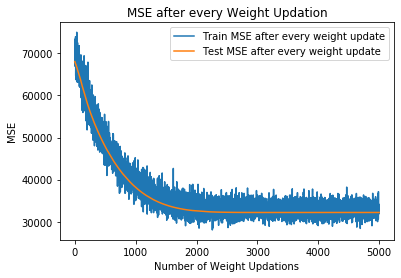

In [92]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(math.ceil(len(train)/math.ceil(len(train)/10))*epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd)
ax1.plot(weight_updates, test_MSE_aft_weight_upd)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

# ADDRESSING the 2 QUESTIONs

# 1. Does increasing number of weights(nodes), by keeping 1 hidden layer impact final MSE  and secondly, does increasing the number of hidden layers impact final MSE?
###    A. Comparing the Final MSE obtained after 500 epochs by varying the number of nodes in the hidden layer 
###### - *Final MSE is the MSE obtained using the final model built after the last weight updation, i.e. after completing the 500th epoch.*

##### In the below code, we are passing the number of nodes as a parameter to the _init_ method of the class so as to control the number of nodes and observe the final MSE. Also we are using 1 hidden layer and only varying the number of nodes in this 1 hidden layer to examine the isolated effect of number of nodes (number of weights) on MSE

In [69]:
class ann_nodes(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self,nodes):
        super().__init__()
        self.hidden_layer1 = nn.Linear(train.shape[1], nodes)  ## 1 hidden layer with 'd' inputs & 'number of nodes' outputs
        self.oput_layer = nn.Linear(nodes,1) ## output layer with 'number of nodes' inputs from hidden layer and 1 output
        
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        out = F.sigmoid(self.hidden_layer1(x))  ## Compute output of 1st hidden layer after applying the Sigmoid function
        output = self.oput_layer(out)   ## compute output of output layer
        return output

#### The below function calculates MSE on a given dataset by using a model. We will invoke this function after the last epoch, i.e. after all the training and weight updation has been completed, to calculate the final train and test MSE

In [70]:
def mse(model,data):
    criterion = nn.MSELoss()
    for inputs,targets in data:
        output = model(inputs)
        loss = criterion(output, targets)
    return loss.item()

#### In the below code, we are writing a for loop to loop over the number of nodes by varying number of nodes from 6 to 26 with an increment of 2.
#### The epochs are kept as 500, as the model converges to global optima within 500 epochs as seen in the above analysis
#### At the end of all the 500 epochs we are using the trained model to obtain Train and Test MSE for each number of Nodes

In [71]:
### Loader with full data as batch to compute MSE on entire train data after last epoch, i.e. after building the model fully
train_loader_full_batch = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = len(train), shuffle = True)

MSE = []  ### List to store MSE after completely training a model, i.e. after the last epoch
test_MSE = [] ### List to store the Test MSE after completely training a model, i.e. after the last epoch

for nodes in range(int(math.floor(train.shape[1]/2)),2*(train.shape[1]+2),2):
    model = ann_nodes(nodes)  ### Initiate the ANN class object named model by passing the number of nodes and initiating the object
    criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error
    optimizer = optim.Adam(model.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

    epochs = 500
    ### Training the dataset.
    for e in range(epochs):
        for inputs,targets in train_loader:    
           # Training pass
            output = model(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
            loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
            loss.backward()   ### Backpropogating based on the loss 
            optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
            optimizer.zero_grad() ### Erasing the gradient values after every weight update
    
    ### Here we store the train and test MSE using the final model after the last epoch all weight updations.
    mse_train = mse(model,train_loader_full_batch)
    mse_test = mse(model,test_loader)
    print(nodes,mse_train,mse_test)
    MSE.append(mse_train)
    test_MSE.append(mse_test)

6 35148.45703125 34234.94140625
8 33523.47265625 32667.1875
10 33115.875 32268.94140625
12 33024.87890625 32210.75
14 33033.94921875 32208.74609375
16 33034.14453125 32209.76953125
18 33031.18359375 32210.0234375
20 33031.3984375 32211.71875
22 33031.3671875 32211.61328125
24 33029.54296875 32211.00390625
26 33030.6796875 32210.275390625


### Formula to get Number of Weights for a network with 1 hidden layer and 1 output node
#### Number of Weights = (Number of Inputs x Number of Nodes in hidden Layer) + Number of Nodes in hidden Layer

In [79]:
no_nodes = [el for el in range(int(math.floor(train.shape[1]/2)),2*(train.shape[1]+2),2)]
print(no_nodes)
no_weights = [(train.shape[1]*el)+el for el in no_nodes]
print(no_weights)

[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
[78, 104, 130, 156, 182, 208, 234, 260, 286, 312, 338]


#### Plot to see the variation in Number of Weights vs final MSE on train and test data
###### We can observe that the MSE decreases with increase in number of nodes (number of weights) till a certain point after which both Train & Test MSE stop decreasing ay further. In this case the Test MSE decreases by ~2000 when the number of nodes increases from 6 to 8 and it further reduces when we increase the number of nodes to 10. But as we go beyond 10 nodes, the MSE does not reduce anymore and we observe a flat trend after 10 nodes, i.e. after 130 weights.

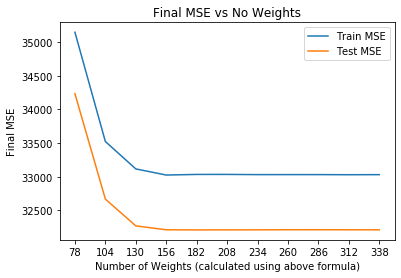

In [87]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(no_weights, MSE)
ax1.plot(no_weights, test_MSE)
ax1.set_xticks(no_weights)
ax1.set_xticklabels(no_weights)
plt.legend(['Train MSE', 'Test MSE'], loc='upper right')
plt.title('Final MSE vs No Weights')
plt.xlabel('Number of Weights (calculated using above formula)')
plt.ylabel('Final MSE')
plt.show()

## B. Comparing the Final MSE obtained after 500 epochs by varying the number of hidden layers
##### - Final MSE is the MSE obtained on the final trained model after the last weight updation, i.e. after completing the 500th epoch.

#### In the below code we are defining 4 ANN classes having 4 different architectures, for 0 hidden layers, 1 hidden layer, 2 hidden layers and 3 hidden layers

In [97]:
class ann_0_hidden_layer(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self,):
        super().__init__()
        self.oput_layer = nn.Linear(train.shape[1],1) ## output layer with 'd' inputs from input layer and 1 output
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        output = self.oput_layer(x)   ## compute output of output layer
        return output

class ann_1_hidden_layer(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self,):
        super().__init__()
        self.hidden_layer1 = nn.Linear(train.shape[1], train.shape[1])  ## 1st hidden layer with 'd' inputs & 'd' outputs
        self.oput_layer = nn.Linear(train.shape[1],1) ## output layer with 'd' inputs from hidden layer and 1 output
        
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        out = F.sigmoid(self.hidden_layer1(x))  ## Compute output of 1st hidden layer after applying the Sigmoid function
        output = self.oput_layer(out)   ## compute output of output layer
        return output
    
class ann_2_hidden_layer(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self,):
        super().__init__()
        self.hidden_layer1 = nn.Linear(train.shape[1], train.shape[1])  ## 1st hidden layer with 'd' inputs & 'd' outputs
        self.hidden_layer2 = nn.Linear(train.shape[1], train.shape[1])  ## 2nd hidden layer with 'd' inputs & 'd' outputs
        self.oput_layer = nn.Linear(train.shape[1],1) ## output layer with 'd' inputs from 2nd hidden layer and 1 output
        
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        out = F.sigmoid(self.hidden_layer1(x))  ## Compute output of 1st hidden layer after applying the Sigmoid function
        out = F.sigmoid(self.hidden_layer2(out))  ## Compute output of 2nd hidden layer after applying the Sigmoid function
        output = self.oput_layer(out)   ## compute output of output layer
        return output

class ann_3_hidden_layer(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self,):
        super().__init__()
        self.hidden_layer1 = nn.Linear(train.shape[1], train.shape[1])  ## 1st hidden layer with 'd' inputs & 'd' outputs
        self.hidden_layer2 = nn.Linear(train.shape[1], train.shape[1])  ## 2nd hidden layer with 'd' inputs & 'd' outputs
        self.hidden_layer3 = nn.Linear(train.shape[1], train.shape[1])  ## 3rd hidden layer with 'd' inputs & 'd' outputs
        self.oput_layer = nn.Linear(train.shape[1],1) ## output layer with 'd' inputs from hidden layer and 1 output
        
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        out = F.sigmoid(self.hidden_layer1(x))  ## Compute output of 1st hidden layer after applying the Sigmoid function
        out = F.sigmoid(self.hidden_layer2(out))  ## Compute output of 2nd hidden layer after applying the Sigmoid function
        out = F.sigmoid(self.hidden_layer3(out))  ## Compute output of 3rd hidden layer after applying the Sigmoid function
        output = self.oput_layer(out)   ## compute output of output layer
        return output

#### In the below code, we are writing a for loop to loop over the number of layers by varying number of layers from 0 to 3
#### The epochs are kept as 500, as the model converges to global optima within 500 epochs as seen in the above analysis and then the final MSE is calculated at end of 500 epochs by using the trained model of each of the 4 model architectures  

In [98]:
### Loader with full data as batch to compute MSE on entire train data after last epoch, i.e. after building the model fully
train_loader_full_batch = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = len(train), shuffle = True)

train_MSE_layers = []  ### List to store MSE after completely training a model, i.e. after the last epoch
test_MSE_layers = [] ### List to store the Test MSE after completely training a model, i.e. after the last epoch
epochs = 500

for layers in [0,1,2,3]:
    if layers == 0:
        model = ann_0_hidden_layer()  ### Initiate the ANN class object named model with 0 hidden layers
    if layers == 1:
        model = ann_1_hidden_layer()  ### Initiate the ANN class object named model with 1 hidden layer1
    if layers == 2:
        model = ann_2_hidden_layer()  ### Initiate the ANN class object named model with 2 hidden layers
    if layers == 3:
        model = ann_3_hidden_layer()  ### Initiate the ANN class object named model with 3 hidden layers
    criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error
    optimizer = optim.Adam(model.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

    ### Training the dataset.
    for e in range(epochs):
        for inputs,targets in train_loader:    
           # Training pass
            output = model(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
            loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
            loss.backward()   ### Backpropogating based on the loss 
            optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
            optimizer.zero_grad() ### Erasing the gradient values after every weight update
    
    ### Here we store the train and test MSE using the final model after the last epoch all weight updations.
    mse_train = mse(model,train_loader_full_batch)
    mse_test = mse(model,test_loader)
    print(layers,mse_train,mse_test)
    train_MSE_layers.append(mse_train)
    test_MSE_layers.append(mse_test)

0 34802.59765625 33907.0234375
1 33038.34765625 32213.76953125
2 33038.20703125 32212.744140625
3 33026.9609375 32212.7734375


#### Plot to see the variation in Number of Hidden Layers VS final MSE of the model on train and test data
###### From the below graph, we can observe that the Train and Test MSE decreases by ~1800 units as we increase the number of hidden layers from 0 to 1. That is because a perceptron is not sufficient to solve this problem with the best performance and this problem requires at least one hidden layer to be solved effectively. However, we can observe that by further increasing the number of hidden layers beyond 1, we are not achieving any further improvement in model performance. The MSE curve flattens after 1 hidden layer, which goes to show that, just 1 hidden is sufficient to solve this problem and for the model to converge to global minima

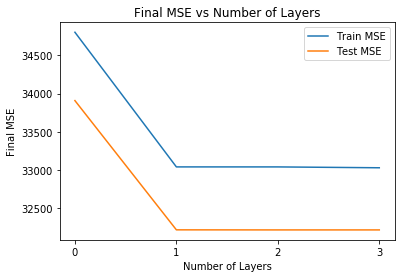

In [99]:
no_layers = [0,1,2,3]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(no_layers, train_MSE_layers)
ax1.plot(no_layers, test_MSE_layers)
ax1.set_xticks(no_layers)
ax1.set_xticklabels(no_layers)
plt.legend(['Train MSE', 'Test MSE'], loc='upper right')
plt.title('Final MSE vs Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Final MSE')
plt.show()

## Plotting a single graph 1 (MSE graph) with both the curves - one for Number of Hidden Layers and one for Number of Weights VS final MSE of the model

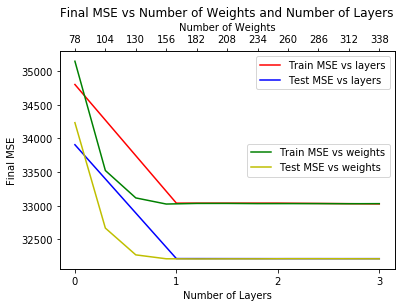

In [118]:
#number_layers_weights = [el for el in range(0,338,10)]
fig, ax1 = plt.subplots()
#fig = plt.figure()
#ax1 = fig.add_subplot(111,label = "1")
#ax2 = fig.add_subplot(111,label = "2", frame_on=False)
ax2 = ax1.twiny()
ax1.plot(no_layers, train_MSE_layers, color='r')
ax1.plot(no_layers, test_MSE_layers, color='b')
ax2.plot(no_weights, MSE, color='g')
ax2.plot(no_weights, test_MSE, color='y')
ax1.set_xticks(no_layers)
ax1.set_xticklabels(no_layers)
ax2.set_xticks(no_weights)
ax2.set_xticklabels(no_weights)
ax1.legend(['Train MSE vs layers', 'Test MSE vs layers'], loc='upper right')
ax2.legend(['Train MSE vs weights', 'Test MSE vs weights'], loc='center right')
plt.title('Final MSE vs Number of Weights and Number of Layers')
ax1.set_xlabel("Number of Layers")
ax2.set_xlabel("Number of Weights")
ax1.set_ylabel('Final MSE')
plt.show()

# 2. Does increasing number of weights(nodes), by keeping 1 hidden layer impact computational effort required to get satisfactory MSE and secondly, does increasing the number of layers impact the same computational effort?

## A. Comparing the Computational Effort (Number of weight updates) required to converge to satisfactory MSE versus the number of nodes in the hidden layer
### We are setting the satisfactory MSE as 33,100. Hence we calculate the computational effort required to attain an MSE of 33,100 or lower.
#### Using the same class ANN Nodes which was defined in the above section which takes in number of nodes as a parameter in the init function. In the below code, if we obtain the desirable MSE on a given batch after a particular weight update, we then evaluate the train and test MSE on the entire train and test data and stop further training/weight updation if we get the desirable train and test mse. The number of weight updates at this point is recorded.

In [122]:
### Loader with full data as batch to compute MSE on entire train data after last epoch, i.e. after building the model fully
train_loader_full_batch = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = len(train), shuffle = True)

Number_weight_updates = []  ### List to store computational effort required to converge to MSE of 33,100 or lower for each value of number of nodes

for nodes in range(int(math.floor(train.shape[1]/2)),2*(train.shape[1]+2),2):
    model = ann_nodes(nodes)  ### Initiate the ANN class object named model by passing the number of nodes and initiating the object
    criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error
    optimizer = optim.Adam(model.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

    epochs = 600
    mse_train = 60000
    mse_test = 60000
    ### Training the dataset.
    for e in range(1,epochs+1):
        batch_no = 0
        breaking_inner = 0
        for inputs,targets in train_loader:
            batch_no = batch_no + 1
           # Training pass
            output = model(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
            loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
            loss.backward()   ### Backpropogating based on the loss 
            optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
            optimizer.zero_grad() ### Erasing the gradient values after every weight update
            if loss.item() <= 33100:
                mse_train = mse(model,train_loader_full_batch) ### Calulating Train and Test MSE on full dataset if the loss of any given batch falls below desirable MSE
                mse_test = mse(model,test_loader)
            if mse_train <= 33100 and mse_test <= 33100:
                breaking_inner = 1
                break
        if breaking_inner == 1:
            break ### Break from the outer loop if we break from the inner loop also and then run for the next value of number of nodes  
        
    ### Here we store the number of weight updates required to attain satisfactory mse and break
    weight_updates = batch_no*e ### Number of weight updates that have happened so far = product of number of batches & epochs iterated through
    print(nodes,weight_updates, mse_train, mse_test)
    Number_weight_updates.append(weight_updates)

6 6000 33612.5546875 32761.2421875
8 1200 33096.41796875 32255.37890625
10 2530 33096.83984375 32255.392578125
12 3960 33098.6015625 32256.212890625
14 3910 33098.734375 32256.337890625
16 2816 33096.88671875 32255.3125
18 636 33096.26953125 32255.294921875
20 1460 33098.41796875 32255.990234375
22 1080 33099.99609375 32256.154296875
24 500 33096.86328125 32255.453125
26 1872 33098.4921875 32255.951171875


#### Plot of Computational Effort to obtain MSE <= 33100(desirable MSE) VS Number of Weights

##### We can observe that for a certain number of weights (nodes in the hidden layer = 8 nodes, 18 nodes & 24 nodes) the computational effort required to obtain a desirable MSE is much lower than the computational effort required for other values of number of weights. For a very low number of weights, the computational effort is very high as shown at the beginning of the graph. This computational effort decreases as we increase the number of weights, and then we observe a fluctuating effect as we further increase the number of weights (number of nodes).   
##### From this graph we can see that keeping 18 nodes in the hidden layer will yield optimum performance and help us attain the desirable MSE with minimum computational effort. 

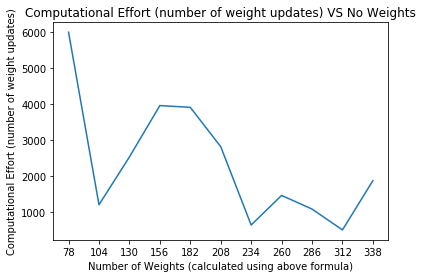

In [124]:
no_nodes = [el for el in range(int(math.floor(train.shape[1]/2)),2*(train.shape[1]+2),2)]

no_weights = [(train.shape[1]*el)+el for el in no_nodes]


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(no_weights, Number_weight_updates)
ax1.set_xticks(no_weights)
ax1.set_xticklabels(no_weights)
plt.title('Computational Effort (number of weight updates) VS No Weights')
plt.xlabel('Number of Weights (calculated using above formula)')
plt.ylabel('Computational Effort (number of weight updates)')
plt.show()

## B. Comparing the Computational Effort (Number of weight updates) required to converge to satisfactory MSE versus the number of hidden layers
#### We are setting the satisfactory MSE as 33,100. Hence we calculate the computational effort required to attain an MSE of 33,100 or lower.
#### Using the same class of ANN hidden layers which was defined in the above section 1. 
#### Also using the same algorithm as above, of stoping further training if the  train and test MSE reach the desirable value and then recording the number of weight updates elapsed till the break point.

In [126]:
### Loader with full data as batch to compute MSE on entire train data after last epoch, i.e. after building the model fully
train_loader_full_batch = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = len(train), shuffle = True)

Number_weight_updates_layers = []  ### List to store computational effort required to converge to MSE of 33,100 or lower for each value of number of nodes
epochs = 600

for layers in [0,1,2,3]:
    if layers == 0:
        model = ann_0_hidden_layer()  ### Initiate the ANN class object named model with 0 hidden layers
    if layers == 1:
        model = ann_1_hidden_layer()  ### Initiate the ANN class object named model with 1 hidden layer1
    if layers == 2:
        model = ann_2_hidden_layer()  ### Initiate the ANN class object named model with 2 hidden layers
    if layers == 3:
        model = ann_3_hidden_layer()  ### Initiate the ANN class object named model with 3 hidden layers
    criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error
    optimizer = optim.Adam(model.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate
    
    mse_train = 60000
    mse_test = 60000
    
    ### Training the dataset.
    for e in range(1,epochs+1):
        batch_no = 0
        breaking_inner = 0
        for inputs,targets in train_loader:    
           # Training pass
            batch_no = batch_no + 1
            output = model(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
            loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
            loss.backward()   ### Backpropogating based on the loss 
            optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
            optimizer.zero_grad() ### Erasing the gradient values after every weight update
            if loss.item() <= 33100:
                mse_train = mse(model,train_loader_full_batch) ### Calulating Train and Test MSE on full dataset using current model if the loss of any given batch falls below desirable MSE
                mse_test = mse(model,test_loader)
            if mse_train <= 33100 and mse_test <= 33100:
                breaking_inner = 1
                break
        if breaking_inner == 1:
            break ### Break from the outer loop if we break from the inner loop also and then run for the next value of number of nodes  
        
    ### Here we store the number of weight updates required to attain satisfactory mse and break
    weight_updates = batch_no*e  ### Number of weight updates that have happened so far = product of number of batches & epochs iterated through
    print(layers,weight_updates, mse_train, mse_test)
    Number_weight_updates_layers.append(weight_updates)

0 6000 34550.38671875 33657.0859375
1 882 33099.5859375 32256.51953125
2 884 33095.96484375 32256.9765625
3 3528 33096.5078125 32255.33984375


#### Plot of Computational Effort to obtain MSE <= 33100(desirable MSE) VS Number of Hidden Layers
#### From the below plot we can observe that Computational Effort required to converge decreases with increase in number of hidden layers till a certain point after which, increasing the number of hidden layers is only requiring more computational effort. In this case choosing 1 or 2 hidden layers would yield the most optimum performance in terms of both MSE and computational effort.

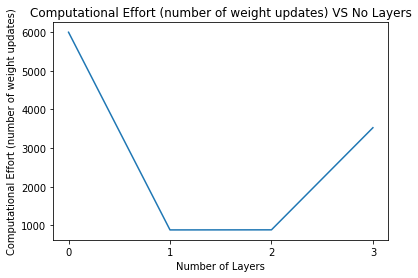

In [127]:
no_layers = [0,1,2,3]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(no_layers, Number_weight_updates_layers)
ax1.set_xticks(no_layers)
ax1.set_xticklabels(no_layers)
plt.title('Computational Effort (number of weight updates) VS No Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Computational Effort (number of weight updates)')
plt.show()

## Plotting a single graph 2 (Computational Effort graph) with both the curves - one for Number of Hidden Layers and one for Number of Weights both plotted against Number of Weight Updates

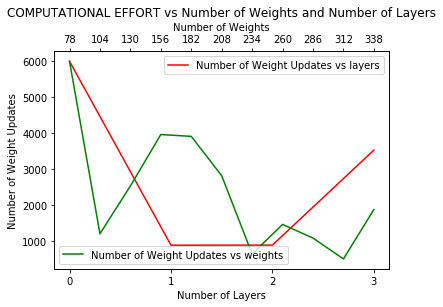

In [133]:
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(no_layers, Number_weight_updates_layers, color='r')
ax2.plot(no_weights, Number_weight_updates, color='g')
ax1.set_xticks(no_layers)
ax1.set_xticklabels(no_layers)
ax2.set_xticks(no_weights)
ax2.set_xticklabels(no_weights)
ax1.legend(['Number of Weight Updates vs layers'], loc='upper right')
ax2.legend(['Number of Weight Updates vs weights'], loc='lower left')
plt.title('COMPUTATIONAL EFFORT vs Number of Weights and Number of Layers')
ax1.set_xlabel("Number of Layers")
ax2.set_xlabel("Number of Weights")
ax1.set_ylabel('Number of Weight Updates')
plt.show()

# Comparing the 2 graphs and drawing a one paragraph Conclusion

### PLOT 1

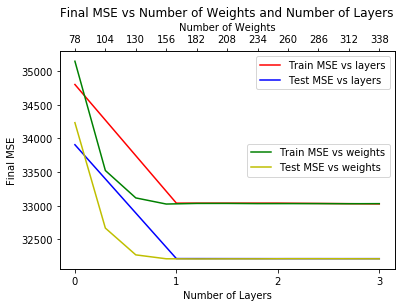

In [136]:
#number_layers_weights = [el for el in range(0,338,10)]
fig, ax1 = plt.subplots()
#fig = plt.figure()
#ax1 = fig.add_subplot(111,label = "1")
#ax2 = fig.add_subplot(111,label = "2", frame_on=False)
ax2 = ax1.twiny()
ax1.plot(no_layers, train_MSE_layers, color='r')
ax1.plot(no_layers, test_MSE_layers, color='b')
ax2.plot(no_weights, MSE, color='g')
ax2.plot(no_weights, test_MSE, color='y')
ax1.set_xticks(no_layers)
ax1.set_xticklabels(no_layers)
ax2.set_xticks(no_weights)
ax2.set_xticklabels(no_weights)
ax1.legend(['Train MSE vs layers', 'Test MSE vs layers'], loc='upper right')
ax2.legend(['Train MSE vs weights', 'Test MSE vs weights'], loc='center right')
plt.title('Final MSE vs Number of Weights and Number of Layers')
ax1.set_xlabel("Number of Layers")
ax2.set_xlabel("Number of Weights")
ax1.set_ylabel('Final MSE')
plt.show()

### PLOT 2

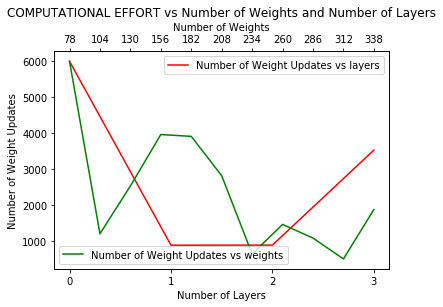

In [134]:
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(no_layers, Number_weight_updates_layers, color='r')
ax2.plot(no_weights, Number_weight_updates, color='g')
ax1.set_xticks(no_layers)
ax1.set_xticklabels(no_layers)
ax2.set_xticks(no_weights)
ax2.set_xticklabels(no_weights)
ax1.legend(['Number of Weight Updates vs layers'], loc='upper right')
ax2.legend(['Number of Weight Updates vs weights'], loc='lower left')
plt.title('COMPUTATIONAL EFFORT vs Number of Weights and Number of Layers')
ax1.set_xlabel("Number of Layers")
ax2.set_xlabel("Number of Weights")
ax1.set_ylabel('Number of Weight Updates')
plt.show()

### CONCLUSION

From the above 2 graphs, we can draw the following conclusion. For this particular dataset and this problem, based on the above plot 1, we can observe that the MSE of a model does improve as we increase the number of hidden layers from 0 to 1 and the number of nodes from 6 to 12. But any further increase in number of nodes or number of hidden layers caused a very inconsiderable or no change in MSE. Hence, based on plot 1 alone we may be willing to finalize a network with more than 1 hidden layer and more than 12 nodes as any network with more than 1 hidden layer and more than 12 nodes is converging to the lowest MSE and yielding the best result. 
However, the second plot takes into consideration the computational effort required and shows us the variation in computational effort with the variation in network shape and size. From this plot 2 we can observe the downside of having a large number of nodes and layers. We can see that increasing the number of layers beyond a point requires more computational effort to converge to global optima. Similarly, increasing the number of nodes can also have a fluctuating or negative impact on computational effort. Moreover, increasing the number of nodes and layers above a certain point is not only negatively impacting computational effort but it is also not causing any improvement in MSE.
Thus, for this problem instead of choosing a very large network, we should pick a network with just 1 hidden layer and 18 nodes (234 weights) in the hidden layer to obtain the best results by putting in the least amount of computational effort.

# END of HOMEWORK 1